<a href="https://colab.research.google.com/github/acse-ns1321/hirise_api_dev/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import cv2

import pandas as pd
import torch
from torch.utils.data import TensorDataset,Dataset, DataLoader,random_split
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from glob import glob
import cv2
import os,sys
os.environ['OPEgrid_columnsV_IO_ENABLE_JASPER'] = 'true'
import numpy as np
from PIL import Image, ImageFile, ImageOps
from tqdm import tqdm
import random
# Ignore warnings
import warnings
import math
warnings.filterwarnings("ignore")

Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os
import torch
import pandas as pd
# from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt

# Import torch packages that help us define our network
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchvision.transforms.transforms import Normalize
from torchvision import datasets, transforms, models

# Package that allows us to summarize our network
from torchsummary import summary


import warnings
warnings.filterwarnings("ignore")

# dir_path = os.path.dirname(os.path.realpath(__file__))
# parent_dir_path = os.path.abspath(os.path.join(dir_path, os.pardir))


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
class Hirise_Image_Dataset(Dataset):
    """Hirise Image dataset."""
    def __init__(self,
                 path_to_images,
                 transform=None):
        # ------------------------------------------------------------------------------
        # path_to_images: where you put the image dataset
        # transform:  data transform
        # img_size: resize all images to a standard size
        # ------------------------------------------------------------------------------

        # Load all the images and their labels
        self.dataset = datasets.ImageFolder(path_to_images, transform=transform)
        self.len = len(self.dataset.imgs)
        self.path_to_images = path_to_images

        # ------------------------------------------------------------------------------
        # Split the data into train and test data 80 : 20
        # ------------------------------------------------------------------------------
        # Calculate the lengths of the vectors
        lengths = [int(np.ceil(len(self.dataset)*0.8)), int(np.floor(len(self.dataset)*0.2))]


        # Extract the images and labels   
        self.train_dataset, self.test_dataset = random_split(self.dataset, lengths)

    def __len__(self):
        # Return the number of samples
        return self.len

    def __getitem__(self, idx):
        sample, target = self.data[idx], self.data[idx]
        sample = sample.view(1, 256, 256).float()/255.
        if self.transform:
            sample = self.transform(sample)
            target = self.transform(target)
        return sample, target

In [13]:

class Data_Preparation:
    """Class that allows for data prepartion as part of the preprocessing of the hirise images. """
    def remove_background(self,file_name):
        src = cv2.imread(file_name, 1)
        tmp = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
        _,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)
        b, g, r = cv2.split(src)
        rgba = [b,g,r, alpha]
        dst = cv2.merge(rgba,4)
        if np.allclose(np.asarray(dst), 0):
            os.remove(file_name)
        else:
            cv2.imwrite(file_name, dst)

    def resize_image(self, folder_path, resized_images_folder_path, pixel_length_cm = 250):
        reduce_factor = 25/pixel_length_cm
        imgfiles = glob(f"{folder_path}/*.IMG")

        # Convert to PIL Imgae
        img_list = []
        for img in tqdm(imgfiles):
            img_list.append(Image.open(img))

        if os.path.isdir(resized_images_folder_path):
            os.chdir(resized_images_folder_path)
        else:
            os.makedirs(resized_images_folder_path)
            os.chdir(resized_images_folder_path)

        for im,name in tqdm(zip(img_list,imgfiles)):         
            resized_im = im.resize((round(im.size[0]*reduce_factor), round(im.size[1]*reduce_factor)))
            print("Hello")
            try:
              print(name)
              resized_im.save(name.split('/')[-1]+'_resizedimage.jpg')
            except:
              pass
            
    def tile_images(self, folder_path,image_directory, image_size_pixels, resized = True,remove_background = True):
        if resized:
            imgfiles = glob(f"{folder_path}/*.jpg")
        else:
            imgfiles = glob(f"{folder_path}/*.IMG")
        # Convert to PIL Imgae
        img_list = []
        for img in imgfiles:
            img_list.append(Image.open(img))

        if os.path.isdir(image_directory):
            os.chdir(image_directory)
        else:
            os.makedirs(image_directory)
            os.chdir(image_directory)

        for img,name in tqdm(zip(img_list,imgfiles)):
            try:
                im = np.asarray(img)
                for r in range(0,math.ceil(im.shape[0]),image_size_pixels):
                    for c in range(0,math.ceil(im.shape[1]),image_size_pixels):
                            f_name = name.split('/')[-1].split('.')[0] + f"_{r}_{c}.jpg"
                            cv2.imwrite(str(f_name), im[r:r+image_size_pixels, c:c+image_size_pixels,:] )
                            if remove_background:
                                Data_Preparation.remove_background(self,file_name =f_name)
            except:
                pass                

        # sys.path.insert(0, parent_dir_path)

    def convert_to_grayscale(self, folder_path,image_directory, remove_background = True):
        imgfiles = glob(f"{folder_path}/*.jpg")

        im_list = []
        # Convert to PIL Imgae
        for img in imgfiles:
            im_list.append(cv2.imread(img, 1))
        
        if os.path.isdir(image_directory):
            os.chdir(image_directory)
        else:
            os.makedirs(image_directory)
            os.chdir(image_directory)

        for img,name in zip(im_list,imgfiles):
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            f_name = "gray_" + name.split('\\')[1]
            try:
                cv2.imwrite(f_name, gray)
            except:
                pass
            if remove_background:
                Data_Preparation.remove_background(self,file_name =f_name)
        # sys.path.insert(0, parent_dir_path)

    def remove_image_with_empty_pixels(self, folder_path, max_percentage_empty_space = 20):
        imgfiles = glob(f"{folder_path}/*.jpg")

        if os.path.isdir(folder_path):
            os.chdir(folder_path)
        else:
            print("ERROR!!")

        for f_name in tqdm(imgfiles):
            empty = 0
            img = Image.open(f_name.split('\\')[1])
            width, height = img.width, img.height
            total = width * height
            for pixel in img.getdata():
                if pixel == (0,0,0,0) or pixel == (0,0,0):            
                    empty += 1
            percent = round((empty * 100.0/total),1)
            if(percent >= max_percentage_empty_space):            
                os.remove(f_name.split('\\')[1])
        # sys.path.insert(0, parent_dir_path)

    def get_image_dataset(self,f_path,  transform_data =  None ):
        if not transform_data:
            transform_data = transforms.Compose([transforms.ToTensor()])
        # transform_data= transforms.Compose([transforms.ToTensor(), transforms.Grayscale(num_output_channels=1)])
        dataset = Hirise_Image_Dataset(path_to_images = f_path, transform = transform_data)

        return dataset

    def get_train_test_val_tensors(self, dataset):
            m=len(dataset.train_dataset)

            train_ds, val_ds = random_split(dataset.train_dataset, [math.floor(m-m*0.2), math.ceil(m*0.2)])
            # ------------------Training Data ----------------------------------------------
            # Empty lists to store the training data
            train_list = []
            # Append from the MedicalMNIST Object the training target and labels
            for data in train_ds:
                train_list.append(data[0])

            train_tensor = torch.Tensor(len(train_list))
            try :
                torch.cat(train_list,out = train_tensor)
            except :
                pass
            # ------------------- --- Test Data ---------------------------------------------
            # Empty lists to store the test data
            test_list = []
            for data in dataset.test_dataset:
                test_list.append(data[0])

            test_tensor = torch.Tensor(len(test_list))
            try:
                torch.cat(test_list,out = test_tensor)
            except :
                pass
            # ------------------- --- Val Data ---------------------------------------------
            # Empty lists to store the test data
            val_list = []
            for data in val_ds:
                val_list.append(data[0])

            val_tensor = torch.Tensor(len(val_list))

            try:
                torch.cat(val_list,out = val_tensor)
            except :
                pass
            return  train_tensor, test_tensor, val_tensor

    def get_train_test_val_dataloader(self, train_data, test_data, val_data,  b_size = 128):
        # Create TorchTensor Datasets containing training_data, testing_data, validation_data
        training_data = TensorDataset(train_data,train_data.long() )
        validation_data = TensorDataset(val_data,val_data.long() )
        testing_data = TensorDataset(test_data, test_data.long())
        train_loader = DataLoader(dataset = training_data, batch_size=b_size)
        valid_loader = DataLoader(dataset = validation_data, batch_size=b_size)
        test_loader = DataLoader(dataset = testing_data, batch_size=b_size,shuffle=True)
        return train_loader,  test_loader, valid_loader

    def show_training_data(self, dataset, grid_rows=5, grid_columns=5):
        """ Prints the traning data in a grid"""
        # Set up axes and subplots
        fig, axarr = plt.subplots(grid_rows, grid_columns, figsize=(10, 10))

        # Loops to run over the grid
        for i in range(grid_rows):
            for j in range(grid_columns):

                # Generate a random index in the training dataset
                idx = random.randint(0, len(dataset.train_dataset))

                # Get the sample and target fromthe traiig dataset
                sample, _ = dataset.train_dataset[idx]

                try:
                    # Exception handling - if it is PIL
                    axarr[i][j].imshow(sample, cmap = "gray")
                except:
                    # If tensor of shape CHW
                    axarr[i][j].imshow(sample.permute(1,2,0), cmap = "gray") 
                # # Get the classes of the target data
                # target_name = dataset.dataset.targets[target]
                # # Label each image eith the target name and the class it belongs to
                # axarr[i][j].set_title("%s (%i)"%(target_name, target))
        # Deine the grid layout and padding
        
        fig.tight_layout(pad=1)
        plt.show()

In [19]:


class CAE_Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            #nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x


In [20]:

class CAE_Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x


In [31]:

latent_dims = 10
num_epochs = 50
batch_size = 128
capacity = 64
learning_rate = 1e-3
use_gpu = True

loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 10

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = CAE_Encoder(encoded_space_dim=d,fc2_input_dim=256)
decoder = CAE_Decoder(encoded_space_dim=d,fc2_input_dim=256)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)



Selected device: cuda


CAE_Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [64]:
folder_path = '/content/drive/MyDrive/Images/img/'
num_epochs = 30
diz_loss = {'train_loss':[],'val_loss':[]}
transform1= transforms.Compose([transforms.ToTensor(), transforms.Resize((28, 28)), transforms.Grayscale(num_output_channels=1)])

dp = Data_Preparation()

dataset1 = dp.get_image_dataset(f_path = folder_path, transform_data = transform1)
tr,tst,val = dp.get_train_test_val_tensors(dataset = dataset1)
train_loader,test_loader, val_l = dp.get_train_test_val_dataloader(tr,tst,val)

In [65]:
img, _ = dataset1.train_dataset[0]
img = img.unsqueeze(0).to(device) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)


img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)

# Decode the image
dec_img = decoder(img_enc)
#dec_img = model(img)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 10])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [80]:
### Training function
def train_CAE(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)
      ### Training function
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        image_batch = image_batch.unsqueeze(0).permute(1,0,2,3)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)


def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.unsqueeze(0).permute(1,0,2,3)
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data
  


def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = dataset1.train_dataset[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

	 partial train loss (single batch): 0.054633
	 partial train loss (single batch): 0.039012

 EPOCH 1/300 	 train loss 0.04682251811027527 	 val loss 0.0466066412627697
	 partial train loss (single batch): 0.052526
	 partial train loss (single batch): 0.037427

 EPOCH 2/300 	 train loss 0.04497649520635605 	 val loss 0.0443735234439373
	 partial train loss (single batch): 0.050528
	 partial train loss (single batch): 0.035935

 EPOCH 3/300 	 train loss 0.04323141276836395 	 val loss 0.04223394766449928
	 partial train loss (single batch): 0.048614
	 partial train loss (single batch): 0.034520

 EPOCH 4/300 	 train loss 0.04156713932752609 	 val loss 0.0403413325548172
	 partial train loss (single batch): 0.046813
	 partial train loss (single batch): 0.033177

 EPOCH 5/300 	 train loss 0.03999496251344681 	 val loss 0.03842907398939133
	 partial train loss (single batch): 0.045076
	 partial train loss (single batch): 0.031920

 EPOCH 6/300 	 train loss 0.03849766403436661 	 val loss 0.0

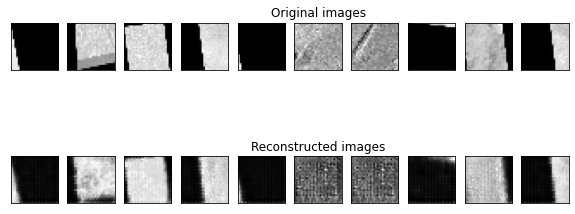

In [82]:
num_epochs = 300
diz_loss = {'train_loss':[],'val_loss':[]}


for epoch in range(num_epochs):
    train_loss =train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
    val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)



plot_ae_outputs(encoder,decoder,n=10)


In [9]:
# dp = Data_Preparation()


In [ ]:
# dp.resize_image(folder_path='/content/drive/MyDrive/data-download',resized_images_folder_path= '/content/drive/MyDrive/data-download/resized-images/',pixel_length_cm = 250)

100%|██████████| 13/13 [00:00<00:00, 86.99it/s]
1it [03:54, 234.47s/it]

Hello
/content/drive/MyDrive/data-download/ESP_026031_2295_UNFILTERED_COLOR.IMG


2it [05:23, 148.95s/it]

Hello
/content/drive/MyDrive/data-download/ESP_030429_2160_UNFILTERED_COLOR.IMG


3it [09:14, 186.51s/it]

Hello
/content/drive/MyDrive/data-download/ESP_025952_2250_UNFILTERED_COLOR.IMG


4it [09:54, 128.37s/it]

Hello
/content/drive/MyDrive/data-download/ESP_028953_1830_UNFILTERED_COLOR.IMG


5it [13:41, 164.25s/it]

Hello
/content/drive/MyDrive/data-download/ESP_032100_1645_UNFILTERED_COLOR.IMG


6it [14:28, 124.16s/it]

Hello
/content/drive/MyDrive/data-download/ESP_020887_1670_COLOR.IMG


7it [16:36, 125.52s/it]

Hello
/content/drive/MyDrive/data-download/ESP_027173_1635_UNFILTERED_COLOR.IMG


8it [18:04, 113.64s/it]

Hello
/content/drive/MyDrive/data-download/ESP_020115_0985_COLOR.IMG


9it [19:42, 108.54s/it]

Hello
/content/drive/MyDrive/data-download/ESP_046350_2310_UNFILTERED_COLOR.IMG


10it [21:04, 100.61s/it]

Hello
/content/drive/MyDrive/data-download/ESP_040829_1590_UNFILTERED_COLOR.IMG


11it [22:10, 89.92s/it] 

Hello
/content/drive/MyDrive/data-download/ESP_045314_1985_UNFILTERED_COLOR.IMG
Hello
/content/drive/MyDrive/data-download/ESP_046329_1725_UNFILTERED_COLOR.IMG


12it [22:23, 66.51s/it]